# UFO 50: Camouflage SSL Segmentation

In [1]:
import os
import pickle
import json
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset

import torchvision.transforms.transforms as tvT
import torchvision.transforms.functional as tvF

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cmap = "tab20"

print(device)

cuda:0


## Load data

> Load two seperate datasets for semi-supervised learning. The first is the labeled data (images and their respective labels), and the second is the unlabeled data (images only).

***Prepare for dataset creation***

In [2]:
class CamoDataset(Dataset):
    def __init__(self, img_dir, label_dir=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        
        self.img_names = sorted(os.listdir(img_dir))
        if label_dir:
            self.label_names = sorted(
                [f for f in os.listdir(label_dir) if f.endswith(".png")])
            with open(os.path.join(label_dir, "mapping.json"), "r") as file:
                self.classes = json.load(file)
                del self.classes["__ignore__"]
        else:
            self.label_names = None
            self.classes = None

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        img = Image.open(img_path).convert("RGB")
        
        if self.label_dir:
            label_path = os.path.join(self.label_dir, self.label_names[idx])
            label = Image.open(label_path)
            if self.transform:
                img, label = self.transform(img, label)
            return img, label
        else:
            if self.transform:
                img = self.transform(img)
            return img

dataset_path = os.path.abspath("../data/datasets/camouflage_1/")
resize_dims = (224, 224)

***Compute image mean/std dev for normalization***

In [3]:
def compute_dataset_stats():
    dataset = CamoDataset(
        f"{dataset_path}/unlabeled", 
        transform=tvT.Compose([
            tvT.Resize(resize_dims, interpolation=tvT.InterpolationMode.NEAREST),
            tvT.ToTensor(),
        ])
    )
    loader = DataLoader(dataset, batch_size=64, num_workers=0)

    mean = 0.0
    std = 0.0
    total_images = 0

    for images in loader:
        images.to(device)
        total_images += images.size(0)
        mean += images.mean(dim=[0, 2, 3]) * images.size(0)
        std += images.std(dim=[0, 2, 3]) * images.size(0)

    mean /= total_images
    std /= total_images
    
    return mean, std

pickle_path = "dataset_stats.pkl"

if os.path.exists(pickle_path):
    with open(pickle_path, "rb") as f:
        mean, std = pickle.load(f)
else:
    mean, std = compute_dataset_stats()
    with open(pickle_path, "wb") as f:
        pickle.dump((mean, std), f)
        
print(mean)
print(std)

tensor([0.2945, 0.3336, 0.2424])
tensor([0.2532, 0.2628, 0.2195])


***Load datasets***

In [4]:
# Define transforms
def transform(img, label=None):
    # Resize
    img = tvF.resize(img, resize_dims)
    if label is not None:
        label = tvF.resize(label, resize_dims, interpolation=Image.NEAREST)
    
    # To Tensor
    img = tvF.to_tensor(img)
    if label is not None:
        label = tvF.to_tensor(label)
    
    # Normalize
    img = tvF.normalize(img, mean=mean, std=std)
    
    if label is not None:
        return img, label.long()
    else:
        return img

labeled_dataset = CamoDataset(f"{dataset_path}/labeled", f"{dataset_path}/labels", transform=transform)
unlabeled_dataset = CamoDataset(f"{dataset_path}/unlabeled", transform=transform)

***Show original image, transformed image, and labels***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2695761..2.6653016].


Text(0.5, 1.0, 'Ground Truth Labels')

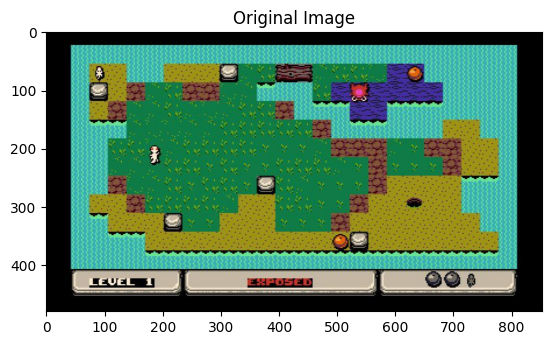

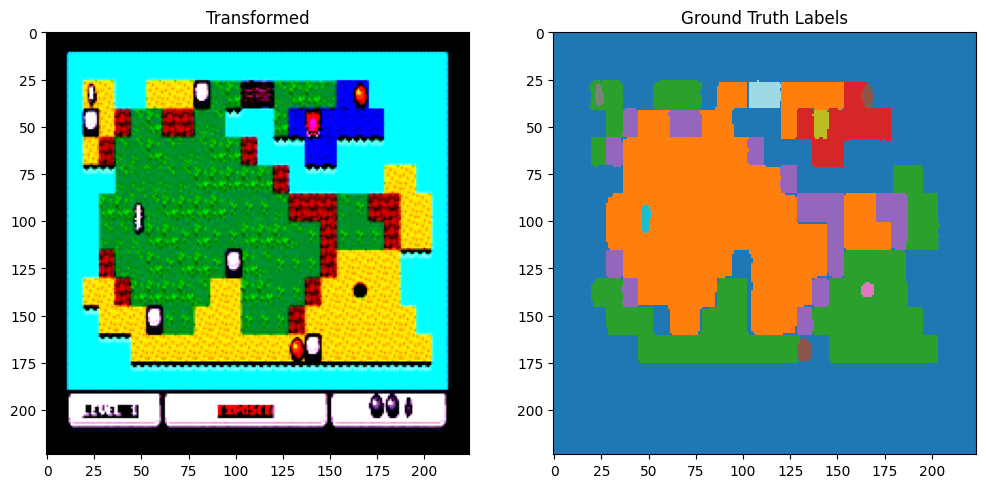

In [5]:
img_idx = 0

img, labels = labeled_dataset[img_idx]
img_name = labeled_dataset.img_names[img_idx]

raw_img_path = os.path.join(dataset_path, "labeled", img_name)
raw_img = Image.open(raw_img_path).convert("RGB")

# Switch axes for viz
img = img.permute(1, 2, 0)
labels = labels.permute(1, 2, 0)

# Visualization
plt.imshow(raw_img)
plt.title("Original Image")
fig, axes = plt.subplots(1, 2, figsize=(12, 10))
axes[0].imshow(img)
axes[0].set_title("Transformed")
axes[1].imshow(labels, interpolation="none", cmap=cmap)
axes[1].set_title("Ground Truth Labels")

## Contrastive pretraining

> Contrastive learning is a self-supervised machine learning technique where samples are encoded in an embedding space in which similar samples are closer than dissimilar samples.
>
> The goal is to transform the data in a way that makes performing tasks such as classification easier for the final model. Better yet, this can be accomplished by using plentiful unlabeled data.
>
> A encoder for contrastive pretraining is created below.

***Prepare for dataset creation***

In [ ]:
# Data agumentation
# norm_params = [0.5 for _ in range(3)]
contrastive_transforms = tvT.Compose([
    tvT.RandomResizedCrop(resize_dims, scale=(0.8, 1.0)),        # Crop
    tvT.RandomHorizontalFlip(),                                    # Flip
    tvT.RandomVerticalFlip(),                                      # Flip
    tvT.RandomApply([tvT.ColorJitter(0.3, 0.3, 0.3, 0.1)], p=0.5), # HSV stuff
    tvT.RandomGrayscale(p=0.5),                                    # Grayscale (learn shapes)
    tvT.ToTensor(),
    tvT.Normalize(mean=mean, std=std)
])

class ContrastiveCamoDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img1 = self.transform(img)
            img2 = self.transform(img)
        return img1, img2

***Define contrastive encoder***

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class ContrastiveModel(nn.Module):
    """
    Model for contrastive pretraining. The encoder can be used in a segmentation
    autoencoder, but the projection head is needed for contrastive learning.

    Currently uses resnet18 and expects 224x224 images as input.
    """
    def __init__(self, projection_dim=128, enc_dims=7):
        super(ContrastiveModel, self).__init__()
        self.encoder = resnet18(weights=None)
        num_features = self.encoder.fc.in_features

        # Projection head (encoder output -> embedding for contrastive learning)
        self.projection = nn.Sequential(
            nn.Linear(num_features * enc_dims * enc_dims, num_features),
            nn.ReLU(),
            nn.Linear(num_features, projection_dim)
        )

    def forward(self, x):
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        x = self.encoder.maxpool(x)

        x = self.encoder.layer1(x)
        x = self.encoder.layer2(x)
        x = self.encoder.layer3(x)
        x = self.encoder.layer4(x)

        # Save flattened output as vector for contrastive learning
        flat = torch.flatten(x, start_dim=1)
        embedded = self.projection(flat)

        return x, embedded
    
def nt_xent_loss(emb_i, emb_j, temperature=0.1):
    batch_size = emb_i.shape[0]
    z = torch.cat([emb_i, emb_j], dim=0)  # (2N, D)
    z = F.normalize(z, dim=1)  # Normalize embeddings

    # Compute similarity matrix
    similarity_matrix = torch.matmul(z, z.T)  # (2N, 2N)
    similarity_matrix = similarity_matrix / temperature

    # Create labels
    labels = torch.arange(batch_size).to(emb_i.device)
    labels = torch.cat([labels + batch_size, labels], dim=0)  # Positive indices

    # Mask self-similarities
    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(emb_i.device)
    similarity_matrix = similarity_matrix.masked_fill(mask, float('-inf'))

    # Compute cross-entropy loss
    loss = F.cross_entropy(similarity_matrix, labels)
    return loss

***Create dataset and loader***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2695761..2.6463413].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2695761..2.7903633].


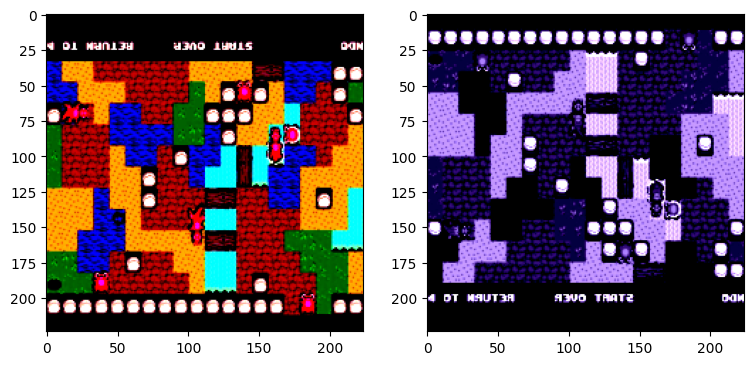

In [8]:
contrastive_dataset = ContrastiveCamoDataset(
    f"{dataset_path}/unlabeled", transform=contrastive_transforms)

# num_samples = 2_000
# indices = random.sample(range(len(contrastive_dataset)), num_samples)
# reduced_dataset = Subset(contrastive_dataset, indices)

# print("Pulling data to memory and transforming...")
# contrastive_dataset_mem = InMemoryDataset(contrastive_dataset)
# print("Pull complete.")

contrastive_batch_size = 128  # Higher == more negative samples == better
contrastive_loader = DataLoader(
    contrastive_dataset,
    batch_size=contrastive_batch_size, shuffle=True, drop_last=True,
    num_workers=0, pin_memory=True
)

img_idx = 3
img1, img2 = next(iter(contrastive_loader))
img1 = img1[img_idx]
img2 = img2[img_idx]
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
axes[0].imshow(img1.permute(1, 2, 0).cpu().numpy())
axes[1].imshow(img2.permute(1, 2, 0).cpu().numpy())
plt.show()

***Pretrain encoder***

In [9]:
def train_contrastive(model, loader, optimizer, epochs):
    model.train()
    grad_scaler = torch.amp.GradScaler()
    
    prev_avg_loss = float("inf")

    for epoch in range(epochs):
        total_loss = 0

        for img1, img2 in loader:
            img1 = img1.to(device, non_blocking=True)
            img2 = img2.to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.autocast(device_type="cuda"):
                _, z_i = model(img1)
                _, z_j = model(img2)
                loss = nt_xent_loss(z_i, z_j)

            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

        # if avg_loss >= prev_avg_loss:
        #     break

        prev_avg_loss = avg_loss

contrastive_model = ContrastiveModel().to(device)
optimizer = torch.optim.Adam(contrastive_model.parameters(), lr=1e-3)

weights_path = "contrastive_model_weights.pth"
epochs = 20

if os.path.exists(weights_path):
    contrastive_model.load_state_dict(torch.load(weights_path, weights_only=True))
    contrastive_model.eval()  # Set the model to evaluation mode
    print(f"Weights loaded successfully from '{weights_path}'.")
else:
    train_contrastive(contrastive_model, contrastive_loader, optimizer, epochs=epochs)
    torch.save(contrastive_model.state_dict(), weights_path)

Epoch [1/20], Loss: 3.9856
Epoch [2/20], Loss: 2.3253
Epoch [3/20], Loss: 2.0929
Epoch [4/20], Loss: 1.8876
Epoch [5/20], Loss: 1.5701
Epoch [6/20], Loss: 1.0934
Epoch [7/20], Loss: 0.8731
Epoch [8/20], Loss: 0.6416
Epoch [9/20], Loss: 0.5028
Epoch [10/20], Loss: 0.3854
Epoch [11/20], Loss: 0.2941
Epoch [12/20], Loss: 0.2579
Epoch [13/20], Loss: 0.2226
Epoch [14/20], Loss: 0.1924
Epoch [15/20], Loss: 0.1776
Epoch [16/20], Loss: 0.1683
Epoch [17/20], Loss: 0.1661
Epoch [18/20], Loss: 0.1481
Epoch [19/20], Loss: 0.1295
Epoch [20/20], Loss: 0.1335


## Train segmentation model

***Prepare data loaders***

In [10]:
from sklearn.model_selection import train_test_split

def get_class_presence(dataset, num_classes):
    # Create a binary matrix where each row corresponds to an image
    # and columns indicate the presence of a class
    class_presence = np.zeros((len(dataset), num_classes), dtype=int)
    for idx, (_, label) in enumerate(dataset):
        label_np = np.array(label)
        unique_classes = np.unique(label_np)
        class_presence[idx, unique_classes] = 1
    return class_presence

batch_size = 16
train_percent = 0.8

# Compute per-image class presence
num_classes = len(labeled_dataset.classes)  # Load from mapping.json
class_presence = get_class_presence(labeled_dataset, num_classes)

# Convert to a per-class label for stratification
# Sum over rows to count the number of images containing each class
per_class_labels = class_presence.sum(axis=1)

# Stratified split based on per-class counts
train_indices, test_indices = train_test_split(
    range(len(labeled_dataset)),
    test_size=(1 - train_percent),
    stratify=per_class_labels
)

C:\Users\eric\AppData\Local\Temp\ipykernel_15204\1600226395.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  label_np = np.array(label)


In [11]:
class FlippedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        x = x.flip(-1)
        return x, y

    def __len__(self):
        return len(self.dataset)
    
class GrayscaleDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        x = tvF.rgb_to_grayscale(x, num_output_channels=3)
        return x, y

    def __len__(self):
        return len(self.dataset)

train_original = torch.utils.data.Subset(labeled_dataset, train_indices)
train_flipped = FlippedDataset(train_original)
train_gray = GrayscaleDataset(train_original)
train_flipped_gray = FlippedDataset(train_gray)
train_dataset = ConcatDataset([train_original, train_flipped, train_gray, train_flipped_gray])

test_dataset = torch.utils.data.Subset(labeled_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

***Define model***

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class SegmentationModel(nn.Module):
    """
    Image segmentation model with concatenation-based skip connections,
    using a pretrained ContrastiveModel encoder.
    """
    def __init__(self, n_classes, encoder):
        super(SegmentationModel, self).__init__()

        # Use the encoder from ContrastiveModel
        self.encoder = encoder  # resnet18 part

        # Decoder layers
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 7x7 -> 14x14
        self.conv4 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 14x14 -> 28x28
        self.conv3 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # 28x28 -> 56x56
        self.conv2 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)    # 56x56 -> 112x112
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Final upsampling and output layer
        self.final_up = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 112x112 -> 224x224
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder ======
        # Extract intermediate feature maps for skip connections
        x1, x2, x3, x4 = self._encoder_forward(x)

        # Decoder ======
        d4 = self.up4(x4)              
        d4 = torch.cat([d4, x3], dim=1)
        d4 = self.conv4(d4)

        d3 = self.up3(d4)              
        d3 = torch.cat([d3, x2], dim=1)
        d3 = self.conv3(d3)

        d2 = self.up2(d3)               
        d2 = torch.cat([d2, x1], dim=1)
        d2 = self.conv2(d2)

        d1 = self.up1(d2)              
        d1 = self.conv1(d1)             

        out = self.final_up(d1)          
        out = self.final_conv(out)      

        return out

    def _encoder_forward(self, x):
        """
        Forward pass through the encoder to extract intermediate feature maps.
        """
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        x = self.encoder.maxpool(x)

        x1 = self.encoder.layer1(x)    # [B, 64, 56, 56]
        x2 = self.encoder.layer2(x1)   # [B, 128, 28, 28]
        x3 = self.encoder.layer3(x2)   # [B, 256, 14, 14]
        x4 = self.encoder.layer4(x3)   # [B, 512, 7, 7]

        return x1, x2, x3, x4

***Train model***

In [13]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=1)

        # One-hot encode the target
        targets_one_hot = F.one_hot(targets, num_classes=logits.shape[1]).permute(0, 3, 1, 2).float()

        # Compute Dice Coefficient
        intersection = (probs * targets_one_hot).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Dice Loss is 1 - Dice Coefficient
        return 1.0 - dice.mean()
    
class TverskyLoss(nn.Module):
    def __init__(self, n_classes, alpha=0.8, beta=0.2, eps=1e-6):
        """
        Tversky loss for imbalanced classes, by default punishes mislabelling
        rare classes w/ high beta

        Args:
            alpha (float): Weight for false positives.
            beta (float): Weight for false negatives.
            eps (float): Smoothing factor to avoid division by zero.
        """
        super(TverskyLoss, self).__init__()
        self.n_classes = n_classes
        self.alpha = alpha
        self.beta = beta
        self.eps = eps

    def forward(self, logits, targets):
        # Convert targets to one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=self.n_classes).permute(0, 3, 1, 2)
        probs = torch.softmax(logits, dim=1)
        
        # Compute true positives, false positives, and false negatives
        tp = (probs * targets_one_hot).sum(dim=(2, 3))
        fp = ((1 - targets_one_hot) * probs).sum(dim=(2, 3))
        fn = (targets_one_hot * (1 - probs)).sum(dim=(2, 3))
        
        # Compute Tversky index
        tversky_index = (tp + self.eps) / (tp + self.alpha * fp + self.beta * fn + self.eps)
        
        # Compute Tversky loss
        tversky_loss = 1 - tversky_index.mean()
        return tversky_loss
    
class AdaptiveTverskyLoss(nn.Module):
    def __init__(self, n_classes, smooth=1e-6):
        super(AdaptiveTverskyLoss, self).__init__()
        self.n_classes = n_classes
        self.smooth = smooth

    def forward(self, logits, targets):
        targets_one_hot = F.one_hot(targets, num_classes=self.n_classes).permute(0, 3, 1, 2)
        probs = torch.softmax(logits, dim=1)
        
        # Compute true positives, false positives, and false negatives
        tp = (probs * targets_one_hot).sum(dim=(2, 3))  # Sum over spatial dimensions
        fp = ((1 - targets_one_hot) * probs).sum(dim=(2, 3))
        fn = (targets_one_hot * (1 - probs)).sum(dim=(2, 3))
        
        # Compute adaptive alpha and beta
        alpha = fp / (fp + tp + self.smooth)  # Shape: [batch_size, n_classes]
        beta = fn / (fn + tp + self.smooth)
        
        # Compute Tversky index
        tversky_index = tp / (tp + alpha * fp + beta * fn + self.smooth)  # Shape: [batch_size, n_classes]
        
        # Compute Tversky loss
        tversky_loss = 1 - tversky_index  # Shape: [batch_size, n_classes]
        return tversky_loss.mean()  # Average over batch and classes

In [14]:
n_classes = len(labeled_dataset.classes)

segmentation_model = SegmentationModel(n_classes=n_classes, encoder=contrastive_model.encoder)
segmentation_model.to(device)

criterion = TverskyLoss(n_classes)
optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-4)

def train_segmentation(model, loader, optimizer, criterion, epochs, print_freq=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0

        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(imgs)
            outputs = F.interpolate(outputs, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            
            loss = criterion(outputs, labels.squeeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)

        if (epoch + 1) % print_freq == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

weights_path = "segmentation_model_weights.pth"
epochs = 200
overwrite = True
if os.path.exists(weights_path) and not overwrite:
    segmentation_model.load_state_dict(torch.load(weights_path, weights_only=True))
    segmentation_model.eval()  # Set the model to evaluation mode
    print(f"Weights loaded successfully from '{weights_path}'.")
else:
    train_segmentation(segmentation_model, train_loader, optimizer, criterion, epochs=epochs)
    torch.save(segmentation_model.state_dict(), weights_path)

Epoch [5/200], Loss: 0.9080
Epoch [10/200], Loss: 0.8484
Epoch [15/200], Loss: 0.8143
Epoch [20/200], Loss: 0.8004
Epoch [25/200], Loss: 0.7916
Epoch [30/200], Loss: 0.7807
Epoch [35/200], Loss: 0.7696
Epoch [40/200], Loss: 0.7454
Epoch [45/200], Loss: 0.7000
Epoch [50/200], Loss: 0.6423
Epoch [55/200], Loss: 0.5852
Epoch [60/200], Loss: 0.4702
Epoch [65/200], Loss: 0.3873
Epoch [70/200], Loss: 0.3439
Epoch [75/200], Loss: 0.3327
Epoch [80/200], Loss: 0.3249
Epoch [85/200], Loss: 0.3209
Epoch [90/200], Loss: 0.3164
Epoch [95/200], Loss: 0.3123
Epoch [100/200], Loss: 0.3045
Epoch [105/200], Loss: 0.3016
Epoch [110/200], Loss: 0.2998
Epoch [115/200], Loss: 0.2983
Epoch [120/200], Loss: 0.2960
Epoch [125/200], Loss: 0.2967
Epoch [130/200], Loss: 0.2945
Epoch [135/200], Loss: 0.2950
Epoch [140/200], Loss: 0.2913
Epoch [145/200], Loss: 0.2923
Epoch [150/200], Loss: 0.2936
Epoch [155/200], Loss: 0.2903
Epoch [160/200], Loss: 0.2898
Epoch [165/200], Loss: 0.2894
Epoch [170/200], Loss: 0.2884


***Test model***

In [15]:
import pandas as pd

def evaluate_segmentation(model, loader, n_classes):
    model.eval()
    correct_pixels = 0
    total_pixels = 0
    iou_per_class = torch.zeros(n_classes, device=device)
    dice_per_class = torch.zeros(n_classes, device=device)
    eps = 1e-6  # To avoid division by zero

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)  # Get predicted classes

            # for i, pred in enumerate(preds):
            #     print(labels[i].unique())
            #     print(pred.unique())
            #     print("===")

            # Pixel accuracy
            correct_pixels += (preds == labels.squeeze(1)).sum().item()
            total_pixels += labels.numel()

            # IoU and Dice Coefficient per class
            for cls in range(n_classes):
                pred_mask = (preds == cls)
                true_mask = (labels.squeeze(1) == cls)

                intersection = (pred_mask & true_mask).sum().float()
                union = (pred_mask | true_mask).sum().float()
                dice = 2 * intersection / (pred_mask.sum().float() + true_mask.sum().float() + eps)

                if union > 0:
                    iou_per_class[cls] += intersection / (union + eps)
                dice_per_class[cls] += dice

    # Aggregate metrics
    pixel_accuracy = correct_pixels / total_pixels
    iou_per_class = iou_per_class / len(loader)
    dice_per_class = dice_per_class / len(loader)

    class_names = list(labeled_dataset.classes.keys())
    metrics_table = pd.DataFrame({
        "Class": class_names,
        "IoU": iou_per_class.cpu().numpy(),
        "Dice": dice_per_class.cpu().numpy()
    })

    display(metrics_table)

    print(labeled_dataset.classes.keys())
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"IoU per class: {iou_per_class.tolist()}")
    print(f"Dice per class: {dice_per_class.tolist()}")

    return metrics_table, pixel_accuracy, iou_per_class.cpu().numpy(), dice_per_class.cpu().numpy()

metrics_table, _, _, _ = evaluate_segmentation(segmentation_model, test_loader, len(labeled_dataset.classes))

,Class,IoU,Dice
0,_background_,0.968133,0.983808
1,Grass,0.951658,0.975229
2,Sand,0.953085,0.975978
3,Marsh,0.922016,0.959424
4,Stone,0.953153,0.975999
5,Orange,0.814860,0.892102
6,Exit,0.970359,0.984957
7,Baby,0.614127,0.720817
8,Enemy,0.685219,0.813103
9,Player,0.296904,0.457234


dict_keys(['_background_', 'Grass', 'Sand', 'Marsh', 'Stone', 'Orange', 'Exit', 'Baby', 'Enemy', 'Player', 'Log', 'RainStone', 'SunStone', 'Button', 'Stairs'])
Pixel Accuracy: 0.9753
IoU per class: [0.968132734298706, 0.9516576528549194, 0.9530853033065796, 0.9220156073570251, 0.9531527757644653, 0.8148601651191711, 0.9703590869903564, 0.6141273975372314, 0.6852186918258667, 0.29690414667129517, 0.8981039524078369, 0.9339940547943115, 0.891753613948822, 0.7107142806053162, 0.8517580032348633]
Dice per class: [0.9838080406188965, 0.9752292633056641, 0.9759784936904907, 0.9594238996505737, 0.9759987592697144, 0.8921021819114685, 0.9849565029144287, 0.7208166718482971, 0.8131028413772583, 0.45723384618759155, 0.9461772441864014, 0.9658699035644531, 0.9427447319030762, 0.8302808403968811, 0.919162929058075]


## Fine-tuning with pseudolabel generation

***Prepare***

In [16]:
class PseudoLabeledDataset(Dataset):
    def __init__(self, unlabeled_dataset, pseudo_labels):
        self.unlabeled_dataset = unlabeled_dataset
        self.pseudo_labels = pseudo_labels

        assert len(unlabeled_dataset) == len(pseudo_labels), (
            "Mismatch: Unlabeled dataset size and pseudo-label size must match."
        )

    def __len__(self):
        return len(self.unlabeled_dataset)

    def __getitem__(self, idx):
        """
        Get an image and its corresponding pseudo-label.
        Args:
            idx (int): Index of the data item.
        Returns:
            tuple: (image, pseudo-label)
        """
        img = self.unlabeled_dataset[idx]
        label = self.pseudo_labels[idx]
        return img, label

def generate_pseudo_labels(model, unlabeled_loader, confidence_threshold=0.8):
    model.eval()
    pseudo_labels = []

    with torch.no_grad():
        for imgs in unlabeled_loader:
            imgs = imgs.to(device)  # Move images to the specified device

            # Forward pass to get predictions
            outputs = model(imgs)  # Raw logits
            probabilities = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

            # Apply confidence threshold
            confidence, predictions = torch.max(probabilities, dim=1)  # Max probability and class indices
            # predictions[confidence < confidence_threshold] = 0  # Assign '0' to low-confidence predictions

            predictions = predictions.unsqueeze(1)

            pseudo_labels.append(predictions.to("cpu"))

    return torch.cat(pseudo_labels, dim=0)

***Fine-tune with pseudolabels***

In [ ]:
optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-4)
criterion = TverskyLoss(n_classes)

iters = 5
epochs = 3
for _ in range(iters):
    # Generate pseudo-labels
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16, shuffle=False)

    print("Generating pseudolabels...", end=" ")
    pseudo_labels = generate_pseudo_labels(segmentation_model, unlabeled_loader)
    print("Done.")

    # Create pseudo-labeled dataset
    pseudo_labeled_dataset = PseudoLabeledDataset(unlabeled_dataset, pseudo_labels)

    # Combine labeled and pseudo-labeled datasets
    combined_dataset = ConcatDataset([labeled_dataset, pseudo_labeled_dataset])

    # Create a new loader for combined dataset
    combined_loader = DataLoader(combined_dataset, batch_size=16, shuffle=True)

    # Train with the combined loader
    train_segmentation(segmentation_model, combined_loader, optimizer, criterion, epochs=epochs, print_freq=1)

***Evaluate***

In [18]:
evaluate_segmentation(segmentation_model, test_loader, len(labeled_dataset.classes))

,Class,IoU,Dice
0,_background_,0.940153,0.969153
1,Grass,0.923660,0.960312
2,Sand,0.902145,0.948504
3,Marsh,0.889757,0.941634
4,Stone,0.915593,0.955927
5,Orange,0.730100,0.842077
6,Exit,0.958084,0.978570
7,Baby,0.432463,0.594386
8,Enemy,0.606220,0.754549
9,Player,0.237963,0.384431


dict_keys(['_background_', 'Grass', 'Sand', 'Marsh', 'Stone', 'Orange', 'Exit', 'Baby', 'Enemy', 'Player', 'Log', 'RainStone', 'SunStone', 'Button', 'Stairs'])
Pixel Accuracy: 0.9579
IoU per class: [0.9401530027389526, 0.923660397529602, 0.9021449089050293, 0.8897571563720703, 0.9155933260917664, 0.7300996780395508, 0.9580841064453125, 0.43246251344680786, 0.6062195897102356, 0.23796285688877106, 0.8320809602737427, 0.7121264934539795, 0.5969347357749939, 0.7319043874740601, 0.7595665454864502]
Dice per class: [0.9691532850265503, 0.9603118896484375, 0.948503851890564, 0.941634476184845, 0.9559274911880493, 0.8420770168304443, 0.978569507598877, 0.5943863987922668, 0.7545486688613892, 0.3844313621520996, 0.9082058072090149, 0.8316630125045776, 0.7473626732826233, 0.8448828458786011, 0.862770676612854]


(           Class       IoU      Dice
 0   _background_  0.940153  0.969153
 1          Grass  0.923660  0.960312
 2           Sand  0.902145  0.948504
 3          Marsh  0.889757  0.941634
 4          Stone  0.915593  0.955927
 5         Orange  0.730100  0.842077
 6           Exit  0.958084  0.978570
 7           Baby  0.432463  0.594386
 8          Enemy  0.606220  0.754549
 9         Player  0.237963  0.384431
 10           Log  0.832081  0.908206
 11     RainStone  0.712126  0.831663
 12      SunStone  0.596935  0.747363
 13        Button  0.731904  0.844883
 14        Stairs  0.759567  0.862771,
 0.95793443442718,
 array([0.940153  , 0.9236604 , 0.9021449 , 0.88975716, 0.9155933 ,
        0.7300997 , 0.9580841 , 0.4324625 , 0.6062196 , 0.23796286,
        0.83208096, 0.7121265 , 0.59693474, 0.7319044 , 0.75956655],
       dtype=float32),
 array([0.9691533 , 0.9603119 , 0.94850385, 0.9416345 , 0.9559275 ,
        0.842077  , 0.9785695 , 0.5943864 , 0.75454867, 0.38443136,
        

***Save final model***

In [ ]:
# weights_path = "final_segmentation_model_weights.pth"
# torch.save(segmentation_model.state_dict(), weights_path)